# GPT Placeholder

In [1]:
GPT_CONFIG_124M  = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qvk_bias": False
}

In [2]:
# building a placeholder GPT module
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.tok_emb = nn.Embedding(config["vocab_size"], config["emb_dim"])
    self.pos_emb = nn.Embedding(config["context_length"], config["emb_dim"])
    self.dropout = nn.Dropout(config["drop_rate"])
    self.transformer_blocks = nn.Sequential(*[DummyTransformerBlock(config) for _ in range(config["n_layers"])])
    self.final_norm = DummyLayerNorm(config["emb_dim"])
    self.out_head = nn.Linear(config["emb_dim"], config["vocab_size"], bias=False)

  def forward(self, in_idx):
    batch, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
    x = tok_embeds + pos_embeds
    x = self.dropout(x)
    x = self.transformer_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

class DummyTransformerBlock(nn.Module):
  def __init__(self, config):
    super().__init__()

  def forward(self, x):
    return x

class DummyLayerNorm(nn.Module):
  def __init__(self, emb_dim, eps = 1e-5):
    super().__init__()

  def forward(self, x):
    return x

In [3]:
%pip install tiktoken

Note: you may need to restart the kernel to use updated packages.


In [4]:
# lets test our model

import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim = 0)
print(batch)


tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [5]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


# Layer Normalization

In [6]:
# understanding layer normalization

torch.manual_seed(123)
batch_example = torch.randn(2, 5)
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)


tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [7]:
# figure the mean and variance of the output

mean = out.mean(dim = -1, keepdim = True)
var = out.var(dim = -1, keepdim = True)
print("mean: \n", mean)
print("variance: \n", var)

mean: 
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
variance: 
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [8]:
# normalize the output
out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim = -1, keepdim = True)
var = out_norm.var(dim = -1, keepdim = True)
print("mean: \n", mean)
print("variance: \n", var)

mean: 
 tensor([[9.9341e-09],
        [0.0000e+00]], grad_fn=<MeanBackward1>)
variance: 
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [9]:
# incorporating layer norm in GPT class
class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self, x):
    mean = x.mean(dim = -1, keepdim = True)
    var = x.var(dim = -1, keepdim = True, unbiased=False)
    norm_x = (x - mean) / torch.sqrt(var + self.eps)
    return self.scale * norm_x + self.shift

In [10]:
# test the LayerNorm class
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim = -1, keepdim = True)
var = out_ln.var(dim = -1, unbiased=False, keepdim = True)
print("mean: \n", mean)
print("variance: \n", var)

mean: 
 tensor([[-2.9802e-08],
        [ 0.0000e+00]], grad_fn=<MeanBackward1>)
variance: 
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


# Implementing a FF NN with GELU activation

In [11]:
# implementing GELU

class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0/torch.pi)) * (x + 0.044715 * torch.pow(x, 3))))

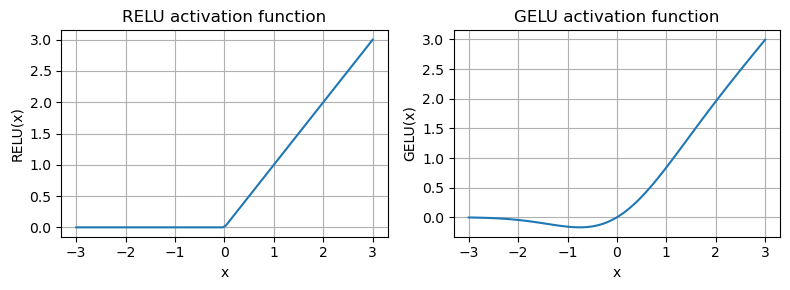

In [12]:
# comparing gelu and relu activations
import matplotlib.pyplot as plt

gelu = GELU()
relu = nn.ReLU()

x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_relu, y_gelu], ["RELU", "GELU"]), 1):
  plt.subplot(1, 2, i)
  plt.plot(x, y)
  plt.title(f"{label} activation function")
  plt.xlabel("x")
  plt.ylabel(f"{label}(x)")
  plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
# implementing the FFNN
class FeedForward(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(config["emb_dim"], 4 * config["emb_dim"]),
        GELU(),
        nn.Linear(4 * config["emb_dim"], config["emb_dim"])
    )

  def forward(self, x):
    return self.layers(x)

In [14]:
# test the ffnn
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.randn(2, 3, 768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


# Adding Residual Networks

In [15]:
# implement a deep nn with residual networks

class DeepNeuralNetwork(nn.Module):
  def __init__(self, layer_sizes, use_shortcut):
    super().__init__()
    self.use_shortcut = use_shortcut
    self.layers = nn.ModuleList([
       self.layer_block(layer_sizes[0], layer_sizes[1]),
       self.layer_block(layer_sizes[1], layer_sizes[2]),
       self.layer_block(layer_sizes[2], layer_sizes[3]),
       self.layer_block(layer_sizes[3], layer_sizes[4]),
       self.layer_block(layer_sizes[4], layer_sizes[5])
    ]);

  def layer_block(self, input_size, output_size):
    return nn.Sequential(nn.Linear(input_size, output_size), GELU());

  def forward(self, x):
    for layer in self.layers:
      layer_output = layer(x)
      if self.use_shortcut and x.shape == layer_output.shape:
        x = x + layer_output
      else:
        x = layer_output
    return x

In [16]:
# lets initialize and test the deep neural network without skip connections and print its gradients

layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)
model_without_shortcut = DeepNeuralNetwork(layer_sizes, use_shortcut = False)

In [17]:
# define the function to print the gradients

def print_gradients(model, x):
  output = model(x)
  target = torch.tensor([0.])

  loss = nn.MSELoss()(output, target)

  loss.backward()

  for name, param in model.named_parameters():
    if 'weight' in name:
      print(f'{name} has gradient mean of {param.grad.abs().mean().item()}')

In [18]:
# print the gradients
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041653171182
layers.3.0.weight has gradient mean of 0.001398873864673078
layers.4.0.weight has gradient mean of 0.005049646366387606


c:\Users\hp\anaconda3\envs\py3.8\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [19]:
# lets initialize and test the deep neural network with skip connections and print its gradients

torch.manual_seed(123)
model_with_shortcut = DeepNeuralNetwork(layer_sizes, use_shortcut = True)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169792652130127
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732502937317
layers.4.0.weight has gradient mean of 1.3258541822433472


# building a transformer block

In [20]:
# implementing Transformer Block
from imports import MultiHeadAttention

class TransformerBlock(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.attn = MultiHeadAttention(
        d_in = config["emb_dim"],
        d_out = config["emb_dim"],
        context_length = config["context_length"],
        num_heads = config["n_heads"],
        dropout = config["drop_rate"],
        qvk_bias = config["qvk_bias"]
    )
    self.ffn = FeedForward(config)
    self.norm1 = LayerNorm(config["emb_dim"])
    self.norm2 = LayerNorm(config["emb_dim"])
    self.dropout_skip = nn.Dropout(config["drop_rate"])

  def forward(self, x):
    skip = x
    x = self.norm1(x)
    x = self.attn(x)
    x = self.dropout_skip(x)
    x = x + skip

    skip = x
    x = self.norm2(x)
    x = self.ffn(x)
    x = self.dropout_skip(x)
    x = x + skip
    return x

In [21]:
# initialize and test the class
# set the context length to 4

GPT_CONFIG_124M_EXAMPLE  = {
    "vocab_size": 50257,
    "context_length": 4,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qvk_bias": False
}

torch.manual_seed(123)
x = torch.randn(2, 4, 768)
transformer_block = TransformerBlock(GPT_CONFIG_124M_EXAMPLE)
out = transformer_block(x)

print("Input shape:", x.shape)
print("Output shape:", out.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


# building the GPTModel

In [22]:
# implementing the GPTModel

class GPTModel(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.tok_emb = nn.Embedding(config["vocab_size"], config["emb_dim"])
    self.pos_emb = nn.Embedding(config["context_length"], config["emb_dim"])
    self.dropout = nn.Dropout(config["drop_rate"])
    self.transformer_blocks = nn.Sequential(
        *[TransformerBlock(config) for _ in range(config["n_layers"])]
    )
    self.final_norm = LayerNorm(config["emb_dim"])
    self.out_head = nn.Linear(config["emb_dim"], config["vocab_size"], bias=False)

  def forward(self, in_idx):
    batch, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(torch.arange(seq_len))
    x = tok_embeds + pos_embeds
    x = self.dropout(x)
    x = self.transformer_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

In [23]:
# initializing and testing the GPT class

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
batch = torch.randint(0, 50257, (2, 1024))
out = model(batch)
print("Input shape:", batch.shape)
print(batch)
print("Output shape:", out.shape)
print(out)

Input shape: torch.Size([2, 1024])
tensor([[25371, 42188, 47556,  ..., 24530, 23973, 42738],
        [10319, 13677, 15405,  ..., 46829, 43675, 36998]])
Output shape: torch.Size([2, 1024, 50257])
tensor([[[-3.8457e-02, -8.1303e-01, -1.7166e-01,  ...,  5.5626e-01,
          -3.7593e-01, -8.5215e-01],
         [-3.7939e-01, -5.3464e-01,  1.6017e-01,  ..., -6.4378e-01,
           2.1574e-01, -2.7445e-01],
         [ 1.9075e+00, -6.0170e-01, -1.2217e+00,  ...,  4.3026e-01,
          -4.2383e-01, -1.3337e+00],
         ...,
         [ 3.5838e-01,  5.0219e-01,  7.7871e-01,  ...,  1.6567e-01,
          -1.4561e+00, -8.8346e-02],
         [-2.0299e-02, -3.4718e-01, -9.8392e-01,  ..., -4.2627e-01,
          -4.6492e-01,  1.0243e+00],
         [-3.6798e-01,  1.3299e-01, -2.2390e-01,  ...,  7.9215e-02,
          -1.3484e+00,  6.1379e-01]],

        [[ 1.5146e-01, -2.4407e-01,  2.0504e-01,  ...,  1.8349e-01,
          -4.4226e-02, -6.6707e-01],
         [-5.9098e-02, -1.5428e-01,  1.0822e+00,  ...,

In [24]:
# print the total no of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total no of parameters: {total_params}.")

Total no of parameters: 163009536.


In [25]:
# there are higher no of parameters
# but in gpt-2 architecture we use a concept called weight typing
# we resue the token embedding layer with output layer
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output head layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output head layer shape: torch.Size([50257, 768])


In [26]:
# so lets remove the output embedding layer wight
total_params_gpt2 = total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Total no of trainable parameters: {total_params_gpt2}.")

Total no of trainable parameters: 124412160.


# Generating text

In [27]:
# generate text sample

def generate_text_simple(model, idx, max_new_tokens, context_size):
  for _ in range(max_new_tokens):
    idx_cond = idx[:, -context_size:]
    with torch.no_grad():
      logits = model(idx_cond)
    logits = logits[:, -1, :]
    probs = nn.functional.softmax(logits, dim = -1)
    idx_next = torch.argmax(probs, dim=-1, keepdim=True)
    idx = torch.cat((idx, idx_next), dim = -1)
  return idx

In [28]:
# try out the generate text method

start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded tensor:", encoded_tensor)

encoded: [15496, 11, 314, 716]
encoded tensor: tensor([[15496,    11,   314,   716]])


In [29]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M_EXAMPLE)
model.eval()
out = generate_text_simple(model, idx = encoded_tensor, max_new_tokens=6, context_size=4)
print(out)

tensor([[15496,    11,   314,   716, 40861, 21189, 28943, 12041, 45265, 50053]])


In [30]:
decoded_text = tokenizer.decode(out[0].tolist())
print(decoded_text)

Hello, I amithering toe resistingPaul gubernatorial Concepts
